# Malmo Project Few-Shot Learning

Guide: https://huggingface.co/blog/setfit

Requires Python 3.7+

`pip install notebook seaborn pandas datasets setfit sentence-transformers torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116`

In [13]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
import torch

In [14]:
# checking for gpu
torch.cuda.is_available()

True

In [15]:
# reading csv files train and test
label_names = {
    0: "Open chest", 
    1: "Smell plant",
    2: "Go to mob",
    3: "Jump in water", 
    4: "Sit next to campfire",
    5: "Play music",
    6: "Go through fence",
    7: "Go inside door",
    8: "Talk to user",
    9: "Move forward",
    10: "Move backward",
    11: "Strafe left",
    12: "Strafe right",
    13: "Pitch upwards",
    14: "Pitch downwards",
    15: "Turn left",
    16: "Turn right",
    17: "Start jumping",
    18: "Stop movement",
    19: "Start crouching",
    20: "Stop crouching",
    21: "Start attacking",
    22: "Stop attacking",
    23: "Use this",
    24: "Stop using this"
}

dtypes = {"text": str, "label": "int8"}
train_df = pd.read_csv("train.csv", dtype=dtypes)
test_df = pd.read_csv("test.csv", dtype=dtypes)

sample = train_df.sample(5)
sample["task_name"] = sample["label"].map(label_names)
sample

,text,label,task_name
41,Sit by the fire,4,Sit next to campfire
89,Let us strafe left,11,Strafe left
61,Go inside house,7,Go inside door
107,Turn right,16,Turn right
45,Heat up next to that fire,4,Sit next to campfire


In [16]:
# loading pretrained model as guide
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


SetFitModel()

In [17]:
# loading own dataset instead of the one in the guide
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files)
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/shah_/.cache/huggingface/datasets/csv/default-a84caa07ebc488fc/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 65
    })
})

In [18]:
# building trainer as guide shows
trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    loss_class=CosineSimilarityLoss,
    batch_size=4,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

In [19]:
# training and getting metrics as shows on guide(just accuracy, I guess)
trainer.train()
metrics = trainer.evaluate()
metrics

***** Running training *****
  Num examples = 5320
  Num epochs = 1
  Total optimization steps = 1330
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1330 [00:00<?, ?it/s]

***** Running evaluation *****


{'accuracy': 0.9692307692307692}

In [20]:
# Test/New Instance Results
df = pd.read_csv("test.csv")
instances = df["text"].to_list()
df["pred"] = model(instances)
df["prob"] = torch.max(model.predict_proba(instances), axis=1).values
df

,text,label,pred,prob
0,"Hey Jerry, open the chest",0,0,0.747906
1,Get me item from storage,0,0,0.416102
2,Open that storage and get me something,0,24,0.406624
3,Get me diamonds from that chest,0,0,0.722323
4,Go to plant in the world,1,1,0.877443
...,...,...,...,...
60,"Hey Jerry, cease the attack",22,22,0.813845
61,"Hey Jerry, use this item",23,23,0.516306
62,"Hey Jerry, close this item",24,24,0.508883
63,Let's close this item,24,24,0.444644


Note how that last input text has very low confidence compared to the others

In [21]:
# Getting valid rows for evaluation / dropping -1 labels
df = df[df.label != -1]

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df["label"], df["pred"])

Accuracy: 1.0


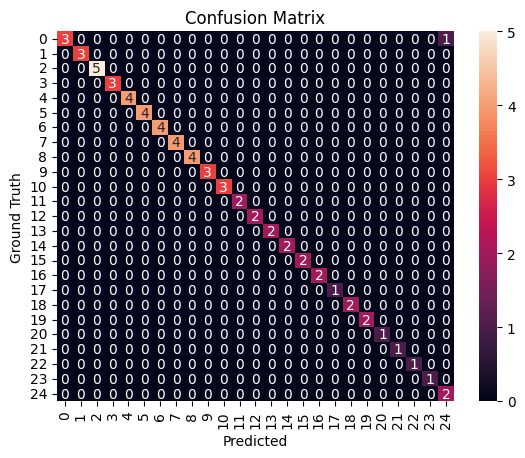

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Accuracy: {len(df['label']==df['pred']) / len(df)}")
# Just plotting for easier read
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names);

In [24]:
# Saving model
trainer.model.save_pretrained("malmoTextClassifier")